In [1]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np
import pickle

import map_functions
import seir_func
import matplotlib.pyplot as plt

In [2]:
cities = ['rj', 'poa', 'fortaleza', 'foz']

In [3]:
len("4,36179287e+09 4,53499800e+03 6,28711552e+06 6,53680000e+00\n 6,53680000e+00 4,58602674e+06 6,53680000e+00 6,53680000e+00\n 1,73440619e+06-1095-0,8296 0,645  1,2778 1,5151 0,9204 1,8608 0,5688 1,8491 1,2515 0,604\n 0,6274 0,8823 0,7417 1,5352 0,7153 1,0552 1,5796.npy")

264

In [4]:
dict_sse = {}
for city in cities:
    time_stamp = 3 * 365
    incidence_real = map_functions.get_cases(city=city)[:time_stamp]
    infected_percentage = incidence_real[0]/map_functions.pop_dict[city]

    print("Infected %: {0}".format(infected_percentage))

    problem = {
      'num_vars': 22,
      'names': ['$o(T)$', '$s_a(T)$',  '$a(T)$', '$p_{hm}$', '$PDR(T)$', '$p_{mh}$',
                 '$u_h$' , '$u_e$',   '$u_v$', '$f_v$', 
                '$d(R)$', '$v_t$', '$K$', '$I_m$',  '$\gamma$',
                '$\delta$', '$i_p$',
                'SEV', 'SIV', 'SV', 'SI', 'SH', 
               ],
      'bounds': [[0.5,2], [0.5, 2], [0.5,2], [0.5,2], [0.5, 2],  [0.5, 2], 
                 [0.5,2], [0.5,2], [0.5,2], [0.5, 2], 
                 [0.5,2], [0.5,2], [0.5,2], [0.0,4], [0.5,2], 
                 [0.5,2], [0.5,2],
                [1,2000], [0,0.01], [0.4,1], [0,0.01], [0,1]]
    }

    # Generate samples
    param_values = saltelli.sample(problem, 240, calc_second_order=True)
    seir = seir_func.seir(city=city)
    sse_array = []
    n = 0
    print("Total number of interactions: {}".format(len(param_values)))
    for params in param_values:
        n += 1
        if n % 5000 == 0:
            print("Iteração {}".format(n))
        estado_inicial = [[
            params[-5], params[-4], 
            params[-3], params[-2], params[-2] , 
            params[-1], params[-1] * infected_percentage, params[-1] * infected_percentage, 1 - params[-1] - 2 * (params[-1] * infected_percentage)
        ]]
        seir.update_parameters(params[:17], estado_inicial)
        incidence_simulated = seir.emulate(time_stamp = time_stamp)
        sse = np.power(np.power(incidence_simulated[:, 9][:time_stamp] - incidence_real, 2).sum(),0.5)
        sse_array.append(sse)
    dict_sse[city] = sse_array

Infected %: 1.039709629894563e-06
Total number of interactions: 11040
Iteração 5000
Iteração 10000
Infected %: 2.0272755737519305e-07
Total number of interactions: 11040
Iteração 5000
Iteração 10000
Infected %: 3.029368268940324e-06
Total number of interactions: 11040
Iteração 5000
Iteração 10000
Infected %: 1.1714723063946769e-05
Total number of interactions: 11040
Iteração 5000
Iteração 10000


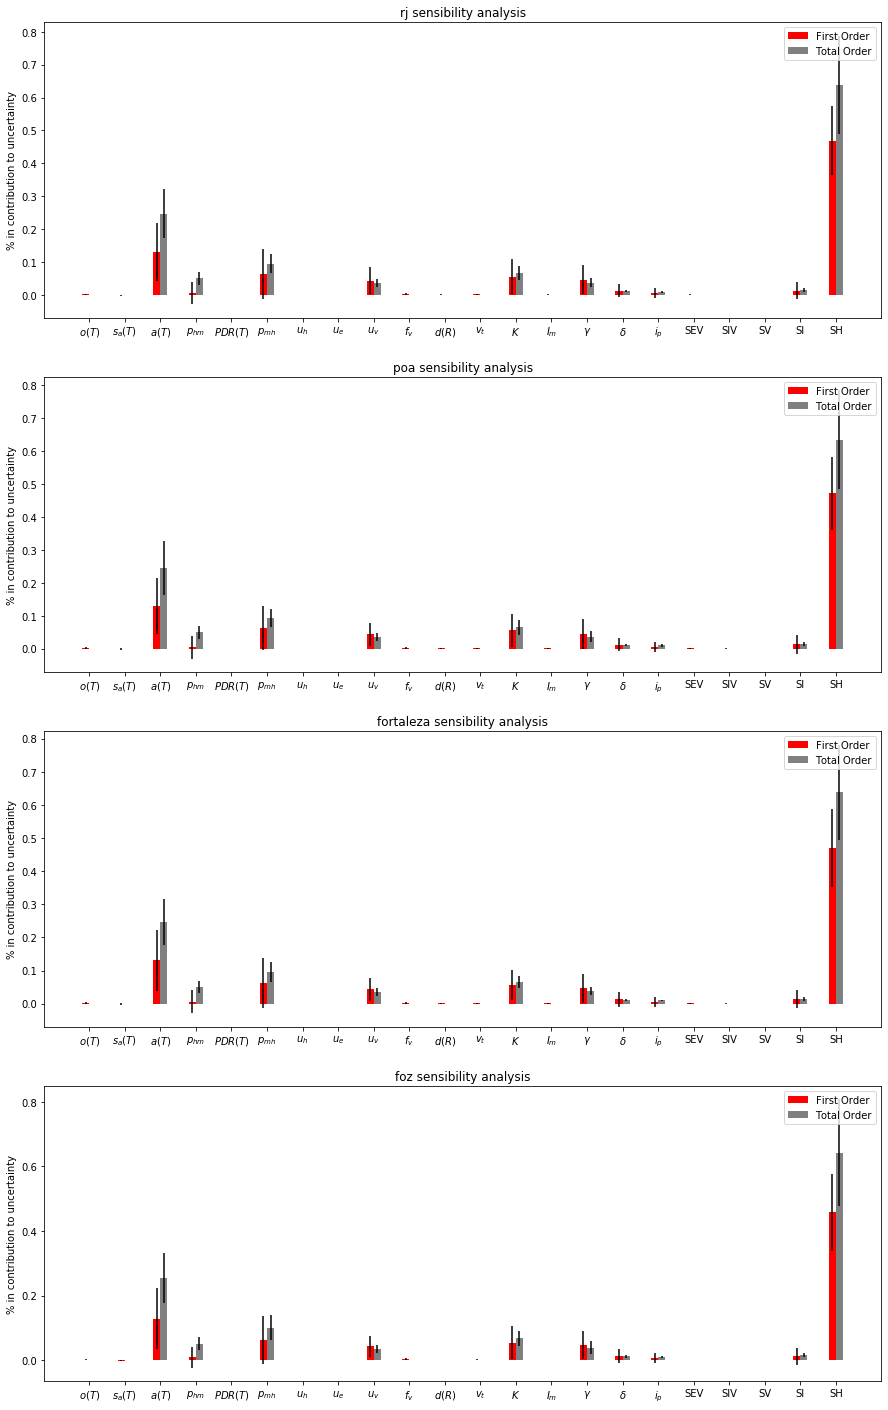

In [5]:
fig = plt.figure(figsize=(15,25))
n = 1
for city_name in cities:
    sse_array = dict_sse[city_name]
    
    Si = sobol.analyze(problem, np.array(sse_array), print_to_console=False)
    x = np.array(range(len(problem['names'])))
    y = np.array(Si['S1'])
    z = np.array( Si['ST'])

    ax = plt.subplot(4, 1, n)
    n += 1
    conf_1 = np.array(Si['S1_conf'])
    conf_t = np.array(Si['ST_conf'])

    ax.bar(x-0.1, y, width=0.2, color='red', align='center', label="First Order", yerr=conf_1)
    ax.bar(x+0.1, z, width=0.2, color='gray', align='center', label="Total Order", yerr=conf_t)

    ax.set_ylabel("% in contribution to uncertainty")
    ax.set_title("{} sensibility analysis".format(city_name))
    ax.set_xticks(x)
    ax.set_xticklabels(problem['names'])
    ax.legend()
fig.savefig("images/sensibility_all_parameters.png")

In [6]:
import scipy.stats as st
from scipy import stats
import pandas as pd

rj sensibility analysis


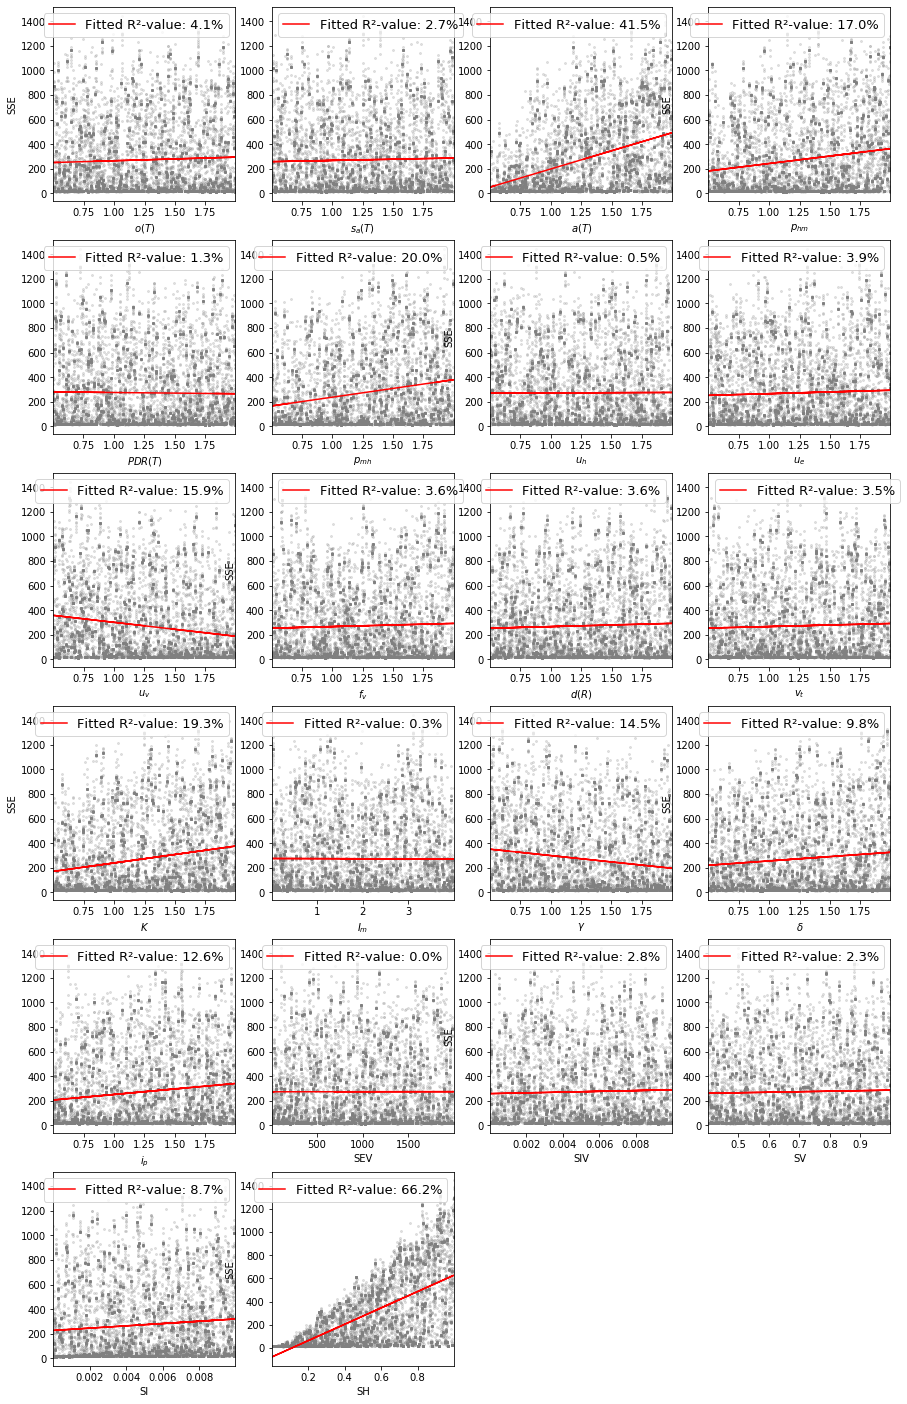

poa sensibility analysis


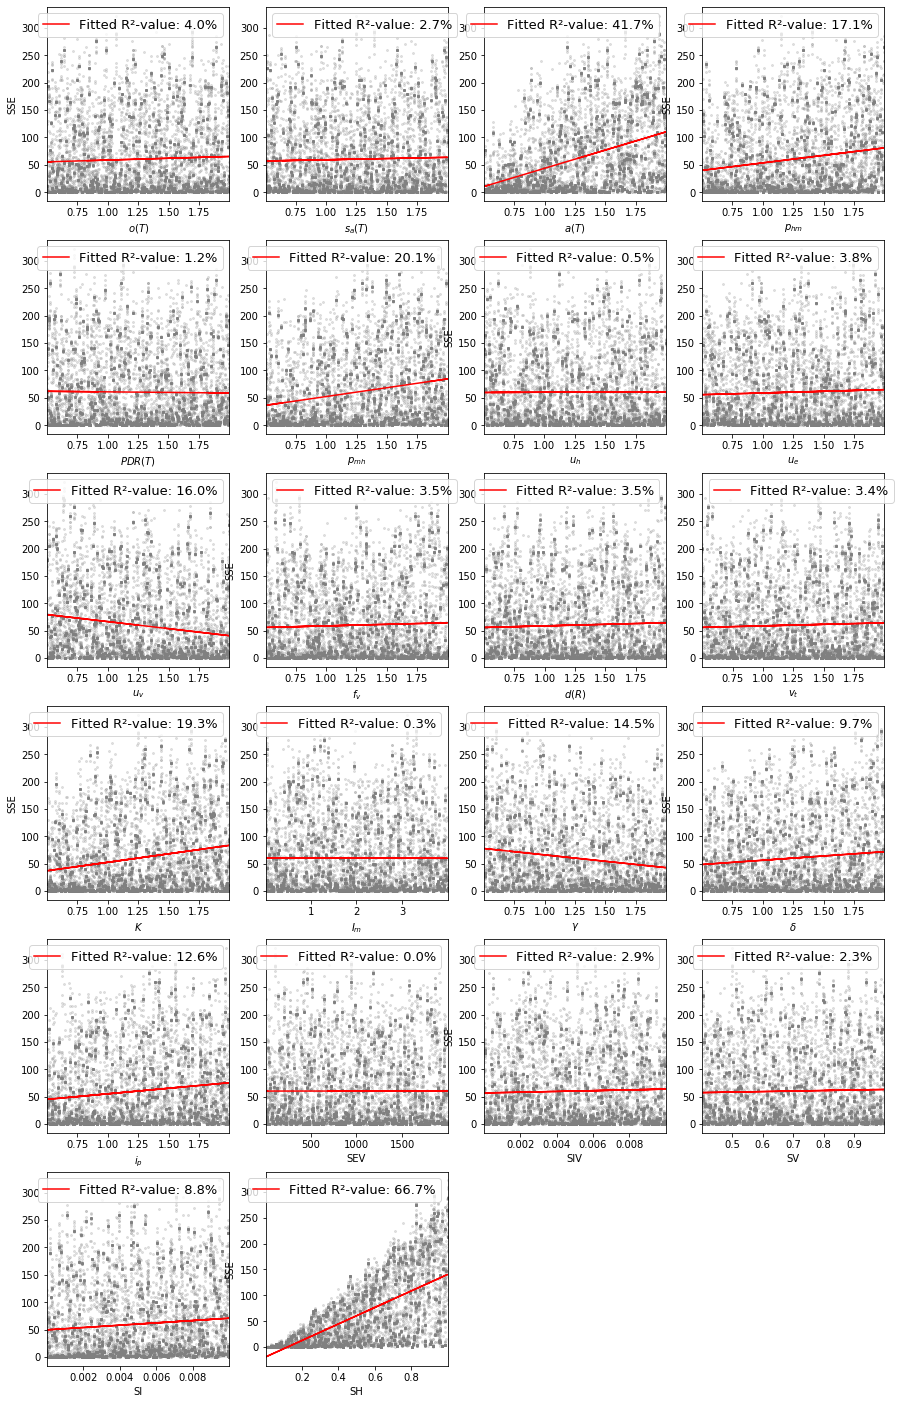

fortaleza sensibility analysis


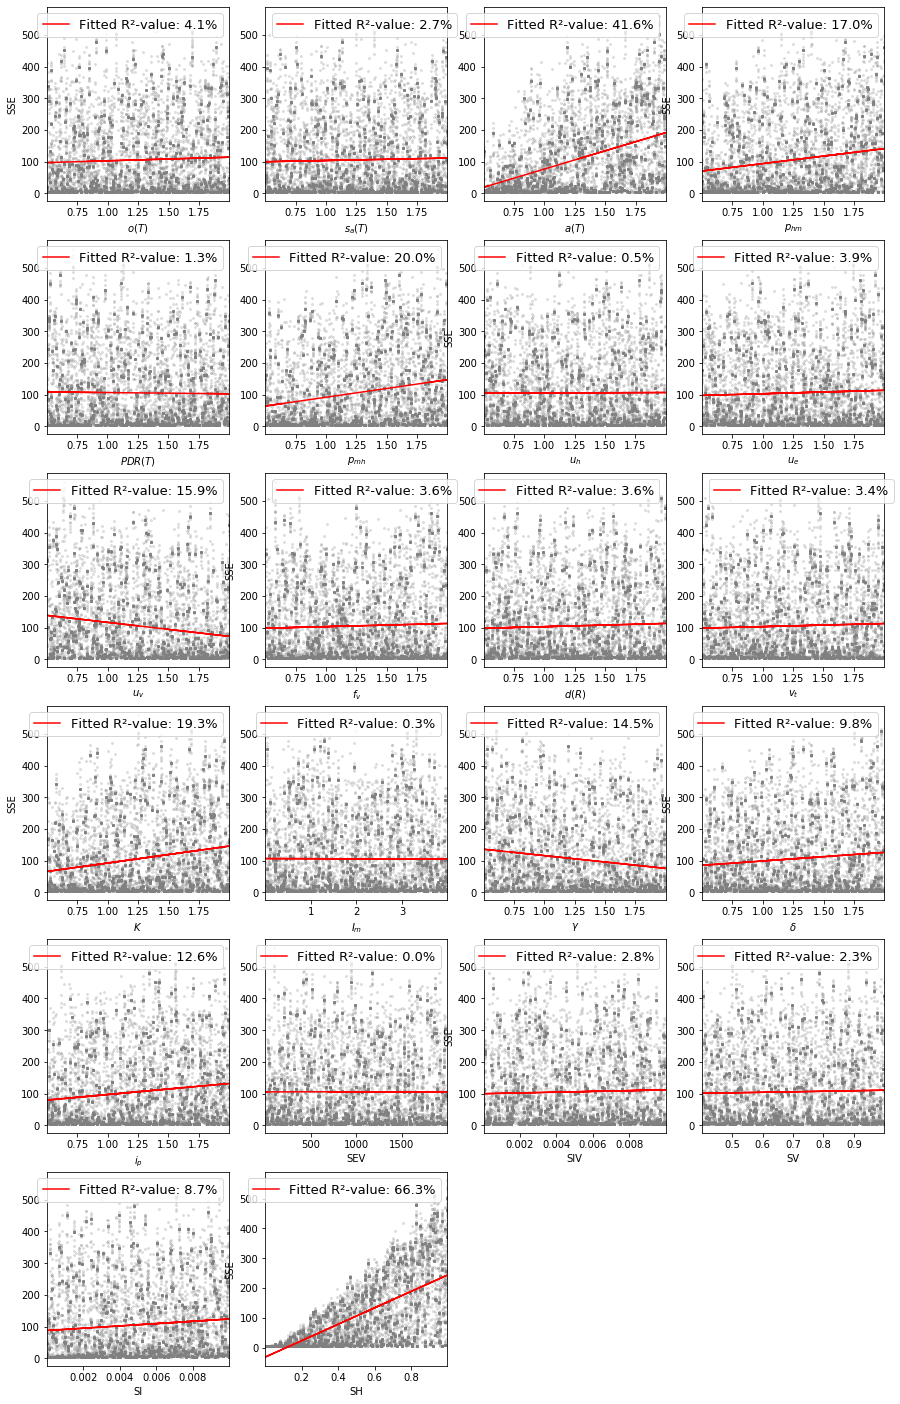

foz sensibility analysis


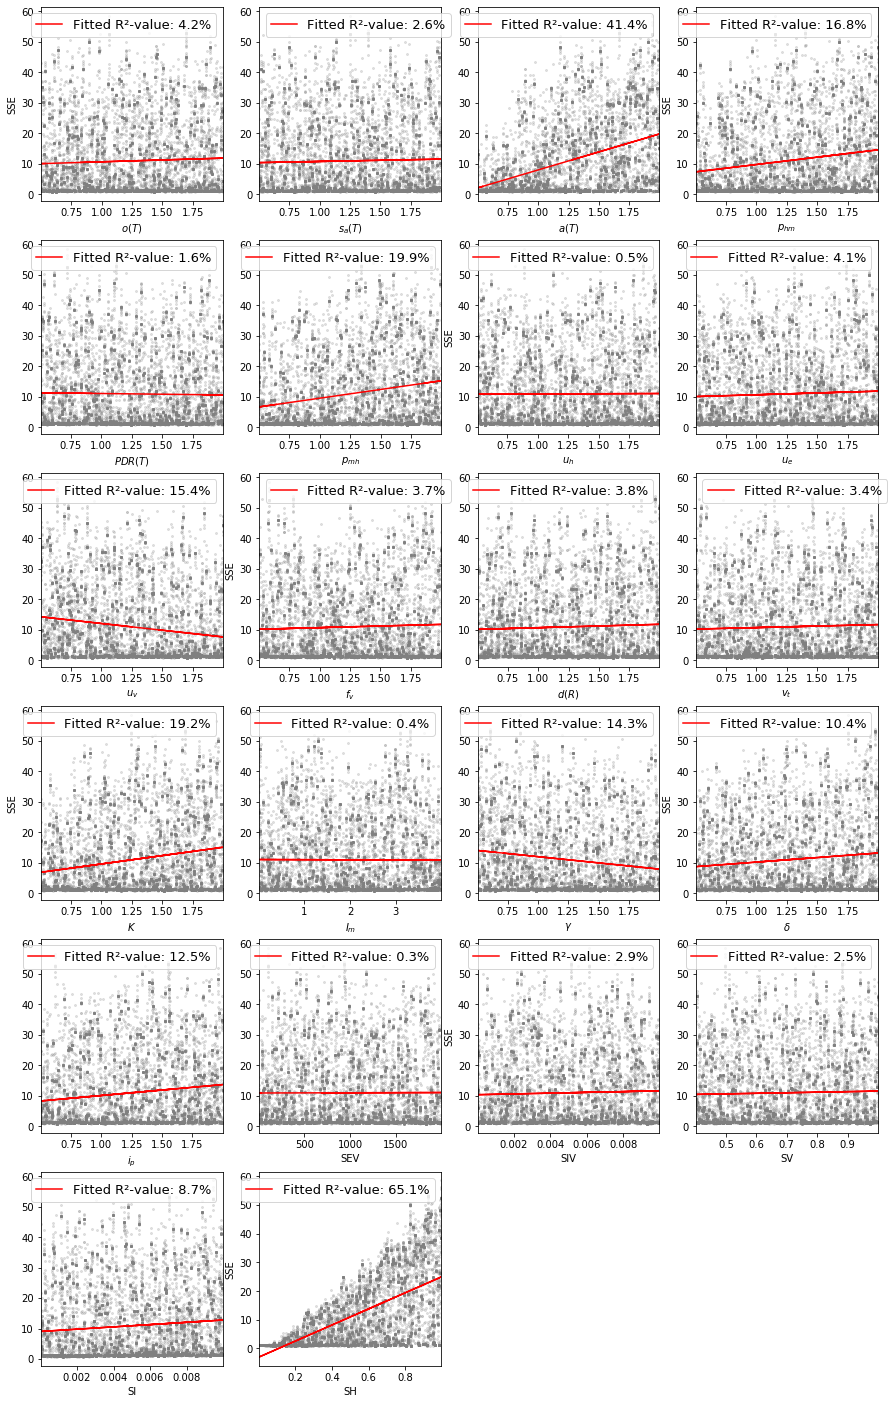

In [7]:
for city_name in cities:
    sse_array = dict_sse[city_name]
    city = city_name
    fig = plt.figure(figsize=(15,25))
    n = 0
    n += 1
    for i in range(len(problem['names'])):
        ax = plt.subplot(6,4,n)
        param_x = [x[i] for x in param_values]
        ax.scatter(param_x, np.array(sse_array)/1000, alpha=0.2, s=4, c='gray')
        slope, intercept, r_value, p_value, std_err = stats.linregress(param_x, np.array(sse_array)/1000)

        plt.plot(param_x, np.array(param_x) * slope + intercept, 'r', 
                 label='Fitted R²-value: {0}%'.format(int(float((r_value**2)**0.5)*1000)/10))
        plt.legend(fontsize=13)
        if (n+2) % 3 == 0:
            ax.set_ylabel("SSE")
        ax.set_xlabel(problem['names'][i])
        ax.set_xlim([min(param_x), max(param_x)])
        n += 1
    print("{} sensibility analysis".format(city_name))
    plt.show()

In [8]:
%matplotlib inline
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.9), borderaxespad=0.05, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})


#sns.set_style('whitegrid')

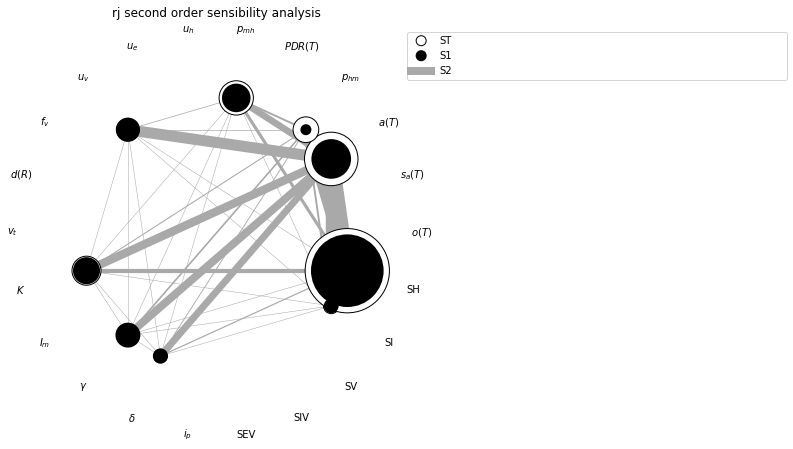

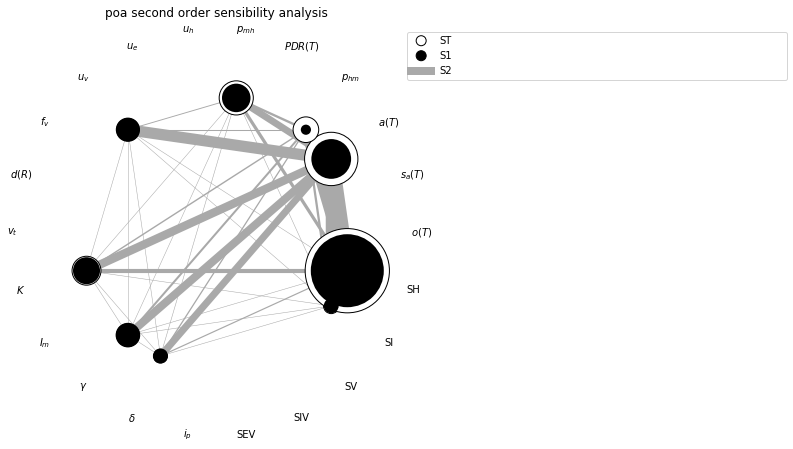

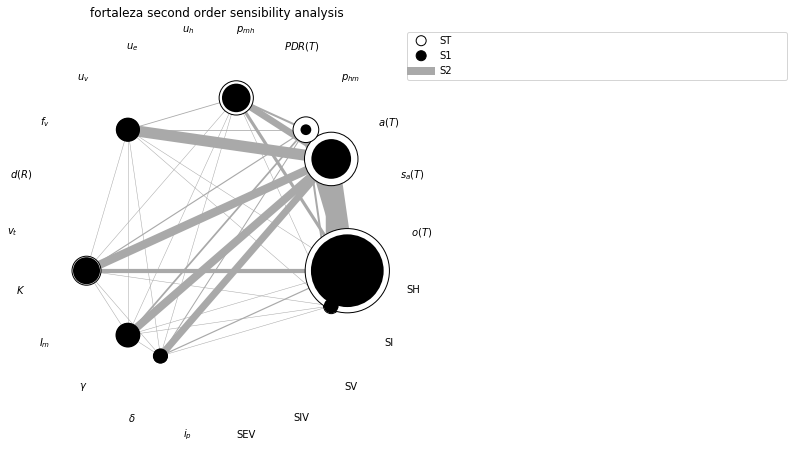

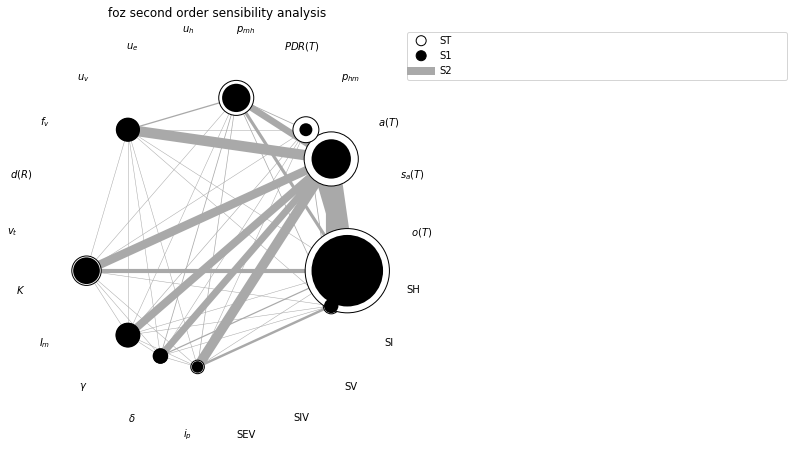

In [9]:
for city_name in cities:
    sse_array = dict_sse[city_name]
    city = city_name
    n = 1
    Si = sobol.analyze(problem, np.array(sse_array), print_to_console=False)
    fig = plot_sobol_indices(Si, criterion='ST', threshold=0.01)
    plt.title("{} second order sensibility analysis".format(city_name))
    fig.set_size_inches(7,7)
    plt.show()
    fig.savefig("images/sensibility_second_order_all_parameters_{}.png".format(city_name))

In [6]:
# Entregar a parte teorica
# Analise de sensibilidade com os parametros
# Analise de sensibilidade só com o estado inicial

# -->:
# Otimização simples para encontrar os parametros mais prováveis. Depois MCMC